# <span style="color:blue">EVAC Workshop 4A: Rule-Based GP in DEAP</span>

**Module leader**

Simon O'Keefe: simon.okeefe@york.ac.uk

**Graduate Teaching Assistants**

Danny Roberts: danny.roberts@york.ac.uk

Tianda Sun: tianda.sun@york.ac.uk

You have already experienced how to use GP, so there is no walkthrough ahead of this workshop. Here, you will learning to program GP to produle a simple rule-based AI and deal with bloat.

# <span style="color:#0073e6">Learning Objectives</span>

- Learn how to program a GP to produce rule-based AI
- Understand and deal with bloat

# <span style="color:Blue">Exercise: Santa Fe Ant Trail Problem</span>

# <span style="color:#0073e6">Context</span>

The artificial ant problem (or Santa Fe Ant Problem) is a well-studied problem with a simple fitness function. The problem is to devise an agent that can successfully navigate an artificial ant along a trail on a square grid to collect as much food as possible within a maximum number of moves (here 600, but you can increase it). You can see a visualization of the problem here:
https://www.youtube.com/watch?v=BKF7pGw8qbY

# <span style="color:#0073e6">Map Setup</span>

Make sure that you have the file santafe_trail.txt in the same folder as the notebook. This text file includes the map for the ants to solve. Open the map in a text editor. You can see that empty cells are represented with periods and food is represented with a hash. There is only one map to work with here, but you can create your own varitions of this in your text editor (e.g. even use code to flip the map).

# <span style="color:#0073e6">The Ant Class</span>

In the code, an ant will follow the instructions provided to it from an individual (an evolved decision tree) evolved by GP. So there is a single ant agent that is used to evaluate your individuals, but a population of individuals that use the ant for evaluation.  A basic way to evaluate fitness is simply looking at how much a particular ant has eaten (ant.eaten), which is implemented here.

An ant can navigate based on three operations:
- Move_Forward	- Move the ant forward one square
- Turn_Right		- Turn the ant to the right 90 degrees
- Turn_Left		- Turn the ant to the left 90 degrees.

These three commands are therefore part of the terminal set in a GP. Each of these operations is assumed to take one time unit to execute.

The sensing function if_food_ahead looks into the square the ant is currently facing and then executes one of its two arguments depending upon whether that square contains food or is empty. Two other functions, Prog2 and Prog3, are provided. These take two and three arguments respectively which are executed in sequence. These three functions are therefore also part of the primitive set.

# <span style="color:Blue">Exercise 1: Complete the GP algorithm</span>

1. Go through the code below and try to understand what it the ant is doing and how the problem works.
2. Complete the genetic programming algorithm to find a solution (as in previous examples). This mainly means completing the primitive set and registering fitness and operators.
3. The best solution in terms of number of food items eaten is 89 for this problem. Can you improve the performance of your algorithm? Be sure to also output your final best solution as tree for examination.

# <span style="color:#0073e6">Ant Code</span>

In [80]:
import copy
from functools import partial

In [81]:
def if_then_else(
    condition: bool, if_true: callable(object), if_false: callable(object)
) -> None:
    if condition:
        if_true()
    else:
        if_false()


class AntSimulator(object):
    direction = ["north", "east", "south", "west"]
    dir_row = [1, 0, -1, 0]
    dir_col = [0, 1, 0, -1]

    def __init__(self, max_moves):
        self.max_moves = max_moves
        self.moves = 0
        self.eaten = 0
        self.routine = None

    def _reset(self):
        self.row = self.row_start
        self.col = self.col_start
        self.dir = 1
        self.moves = 0
        self.eaten = 0
        self.matrix_exc = copy.deepcopy(self.matrix)

    @property
    def position(self):
        return (self.row, self.col, self.direction[self.dir])

    def turn_left(self):
        if self.moves < self.max_moves:
            self.moves += 1
            self.dir = (self.dir - 1) % 4

    def turn_right(self):
        if self.moves < self.max_moves:
            self.moves += 1
            self.dir = (self.dir + 1) % 4

    def move_forward(self):
        if self.moves < self.max_moves:
            self.moves += 1
            self.row = (self.row + self.dir_row[self.dir]) % self.matrix_row
            self.col = (self.col + self.dir_col[self.dir]) % self.matrix_col
            if self.matrix_exc[self.row][self.col] == "food":
                self.eaten += 1
            self.matrix_exc[self.row][self.col] = "passed"

    def sense_food(self):
        ahead_row = (self.row + self.dir_row[self.dir]) % self.matrix_row
        ahead_col = (self.col + self.dir_col[self.dir]) % self.matrix_col
        return self.matrix_exc[ahead_row][ahead_col] == "food"

    def if_food_ahead(self, out1, out2):
        return partial(if_then_else, self.sense_food, out1, out2)

    def run(self, routine):
        self._reset()
        while self.moves < self.max_moves:
            routine()

    def parse_matrix(self, matrix):
        self.matrix = list()
        for i, line in enumerate(matrix):
            self.matrix.append(list())
            for j, col in enumerate(line):
                if col == "#":
                    self.matrix[-1].append("food")
                elif col == ".":
                    self.matrix[-1].append("empty")
                elif col == "S":
                    self.matrix[-1].append("empty")
                    self.row_start = self.row = i
                    self.col_start = self.col = j
                    self.dir = 1
        self.matrix_row = len(self.matrix)
        self.matrix_col = len(self.matrix[0])
        self.matrix_exc = copy.deepcopy(self.matrix)

The 'parse_matrix' function processes the map and stores it in the 2D list 'matrix_exc', and the other functions simply move or turn the ant around.

*Side note: in case you're not familiar @property is a standard Python decorator that allows you do to setting and getting variables. It's beyond the scope of the module to discuss this, and you don't need to understand it for this workshop. If you're interested you can read more here:
https://www.programiz.com/python-programming/property*

In [82]:
ant = AntSimulator(600)  # This is the number of moves

with open("data/santafe_trail.txt") as trail_file:
    ant.parse_matrix(trail_file)

## <span style="color:#0073e6">You need to decide on your GP below</span>

We now need to define our primitive set. There are some common mistakes when defining the "Main" function. You can see that the ant uses information from the environment. However, if you look at the code, the ant object directly accesses the environment, and it is not passed to the evolved function as an argment -- don't add these as arguments, this code has zero arguments. However, you could modify the code to pass the arguments, if you liked, and then would need to modify it here.

Don't forget that here you might need to define and register progs (allowing multiple functions to connect together) and your own functions (e.g. if_then_else). No cheating and registering pre-programmed behaviour, though!

Your terminals are the ant behaviour. So for example:
> pset.addTerminal(ant.move_forward)

In [83]:
from deap import tools, base, creator, gp, algorithms

pset = gp.PrimitiveSet("main", 0)

I have left a couple of examples in here to get you started with the primitive set.

In [84]:
def progn(*args):
    for arg in args:
        arg()


def prog2(out1, out2):
    return partial(
        progn, out1, out2
    )  # partial allows this to be a more specific (two argument) version of progn


def prog3(out1, out2, out3):
    return partial(progn, out1, out2, out3)


def prog4(out1, out2, out3, out4):
    return partial(progn, out1, out2, out3, out4)


pset.addPrimitive(prog2, 2)
pset.addPrimitive(prog3, 3)
# pset.addPrimitive(prog4, 4)
pset.addTerminal(ant.move_forward)
pset.addTerminal(ant.turn_right)
pset.addTerminal(ant.turn_left)
pset.addPrimitive(ant.if_food_ahead, 2)

In [85]:
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMax)
toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=3, max_=8)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)


def evalAnt(individual):
    routine = toolbox.compile(expr=individual)
    ant.run(routine)
    return (ant.eaten,)


toolbox.register("evaluate", evalAnt)

(0,)


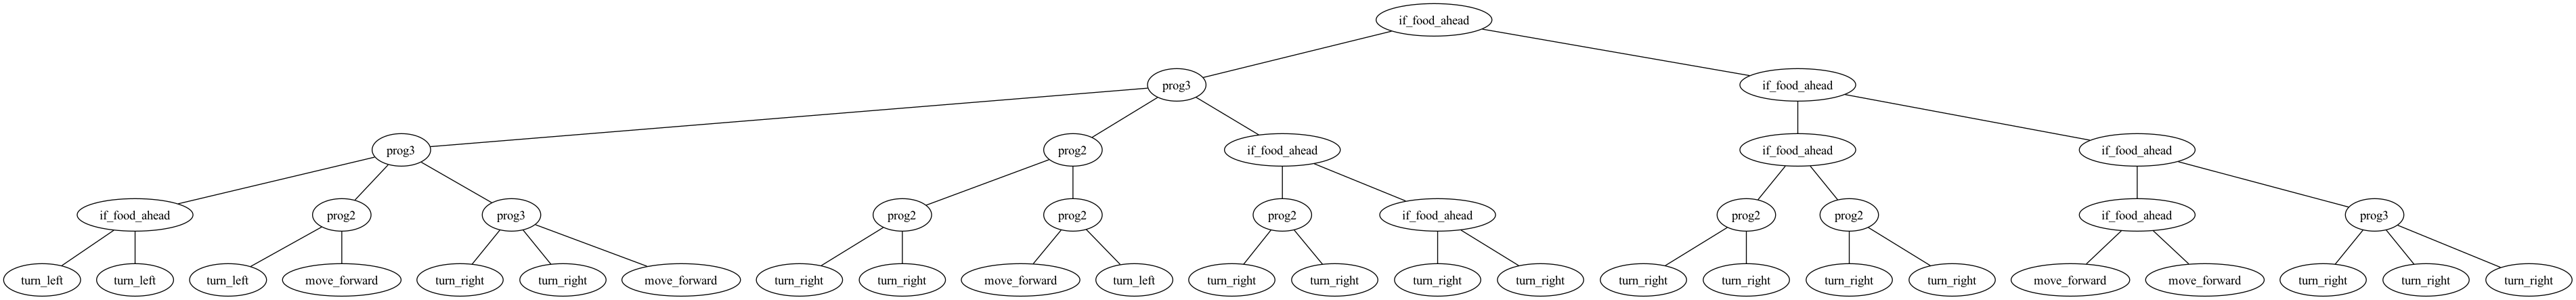

In [86]:
import pygraphviz as pgv
from IPython.display import Image

ind = toolbox.individual()

nodes, edges, labels = gp.graph(ind)
tree = pgv.AGraph()
tree.add_nodes_from(nodes)
tree.add_edges_from(edges)
tree.layout(prog="dot")

for i in nodes:
    n = tree.get_node(i)
    n.attr["label"] = labels[i]

treePlot = tree.draw(format="png", prog="dot")
print(toolbox.evaluate(ind))
Image(treePlot)

For the **evaluation function** for this task, you can see that the ant class has a routine to run through your compiled solution a number of timesteps.

In [87]:
import numpy

stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
stats_size = tools.Statistics(len)
mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
mstats.register("avg", numpy.mean)
mstats.register("std", numpy.std)
mstats.register("min", numpy.min)
mstats.register("max", numpy.max)
pop = toolbox.population(n=500)
hof = tools.HallOfFame(1)

pop, log = algorithms.eaSimple(
    pop,
    toolbox,
    cxpb=0.5,
    mutpb=0.1,
    ngen=150,
    stats=mstats,
    halloffame=hof,
    verbose=True,
)

   	      	                    fitness                    	                     size                     
   	      	-----------------------------------------------	----------------------------------------------
gen	nevals	avg  	gen	max	min	nevals	std    	avg   	gen	max 	min	nevals	std   
0  	500   	4.964	0  	31 	0  	500   	5.58271	261.47	0  	2461	15 	500   	442.79
1  	282   	9.256	1  	31 	0  	282   	5.91189	507.536	1  	2461	3  	282   	595.179
2  	270   	13.024	2  	31 	0  	270   	5.47681	678.372	2  	2463	12 	270   	661.274
3  	281   	15.794	3  	31 	0  	281   	5.79306	640.798	3  	2282	12 	281   	615.062
4  	262   	17.318	4  	31 	0  	262   	6.60522	511.18 	4  	2102	7  	262   	562.418
5  	273   	18.816	5  	31 	0  	273   	7.22455	414.072	5  	2089	27 	273   	527.928
6  	286   	19.75 	6  	31 	0  	286   	8.15742	361.714	6  	2091	23 	286   	510.416
7  	271   	21.094	7  	31 	0  	271   	8.88173	307.186	7  	2096	39 	271   	447.795
8  	282   	22.238	8  	31 	0  	282   	10.0406	244.394	8  	1941	3  	

(65.0,)


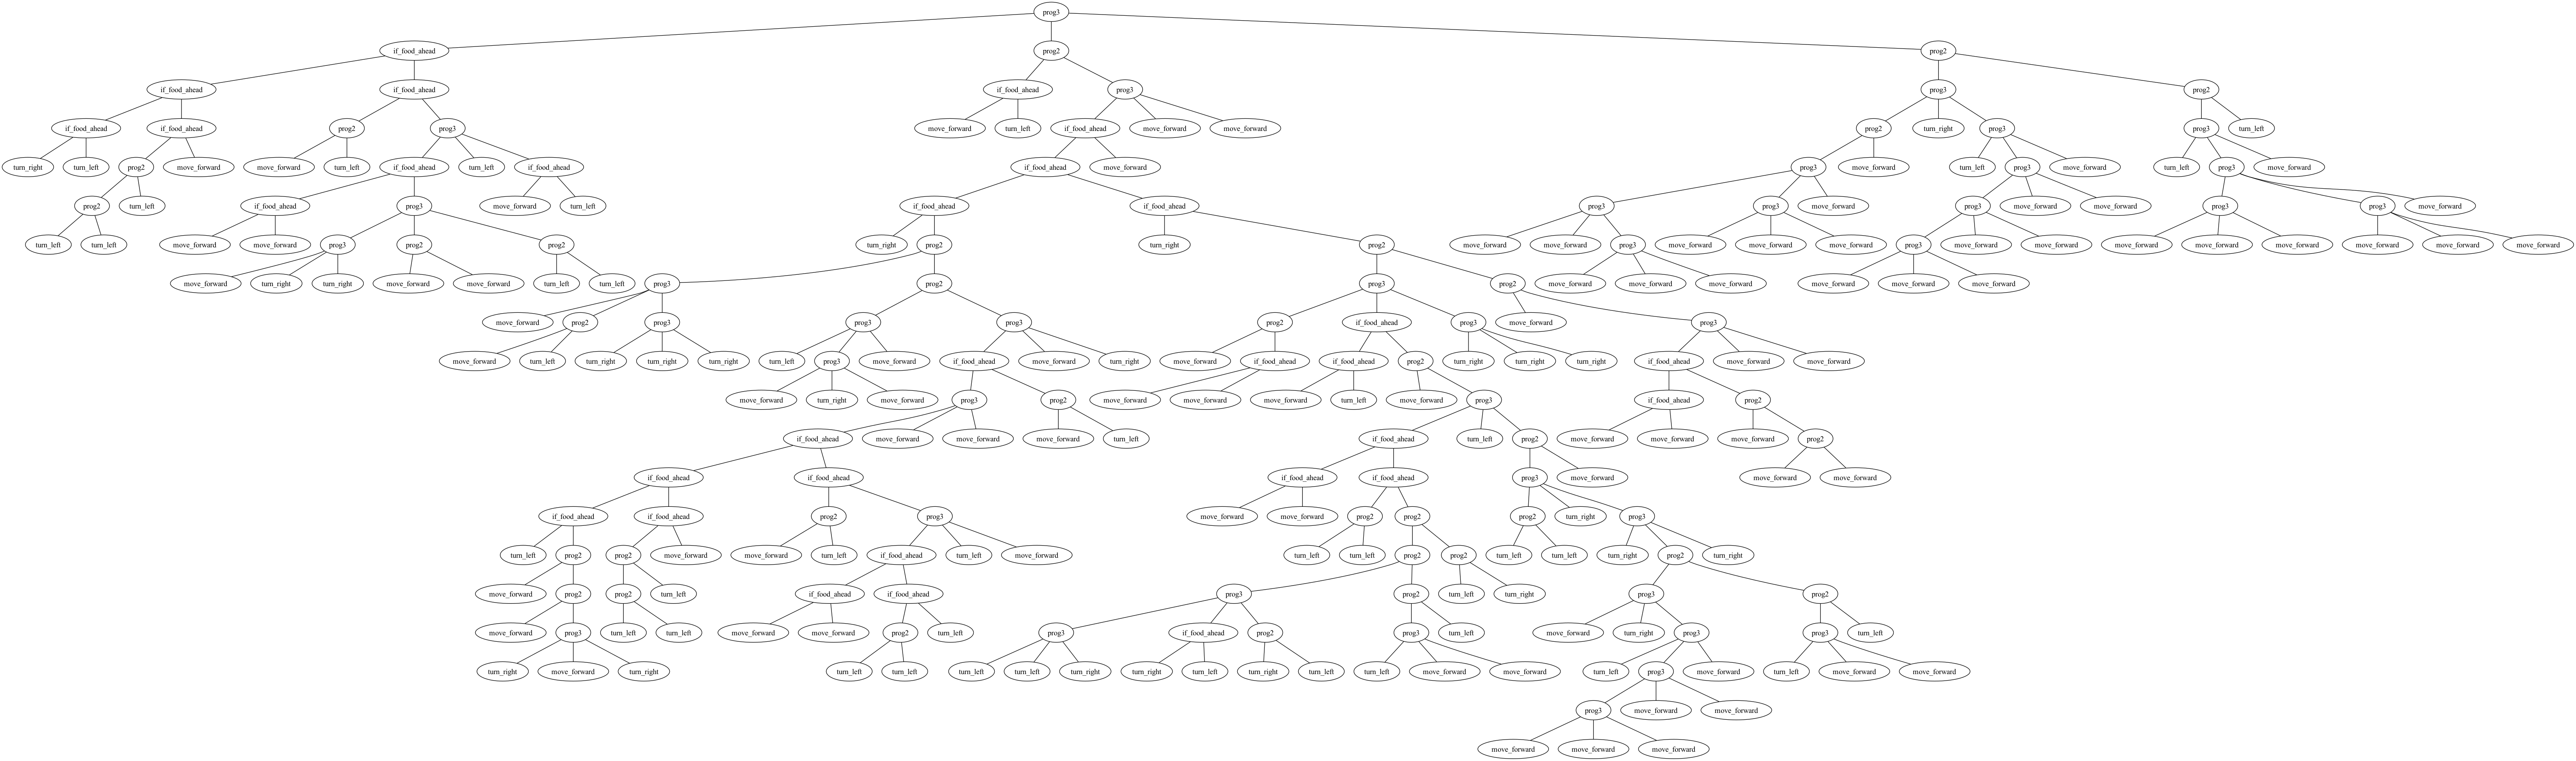

In [88]:
best_ind = tools.selBest(pop, 1)[0]

ind = toolbox.individual()

nodes, edges, labels = gp.graph(best_ind)
tree = pgv.AGraph()
tree.add_nodes_from(nodes)
tree.add_edges_from(edges)
tree.layout(prog="dot")

for i in nodes:
    n = tree.get_node(i)
    n.attr["label"] = labels[i]

treePlot = tree.draw(format="png", prog="dot")
print(best_ind.fitness)
Image(treePlot)

# <span style="color:Blue">Exercise 2: Dealing with Bloat</span>

You should see from plotting the tree of the best individual, that there is bloat. Let's examine how to deal with this.

1. Try a simple modification to the evaluation function by adding a ‘parsimony penalty’ term to the fitness. This is a penality that increases as a function of the height of the tree ( individual.height ).
2. Now remove the bloat penalty. If parsimony penalties like this are not done carefully for some problems, it could give undesirable results. Instead implement a double tournament. Go to the DEAP library reference (https://deap.readthedocs.io/en/master/api/index.html) and look for the selection operator selDoubleTournament(). This will vastly help you to contain bloat in a better manner. Implement this, and play with the parameters a little. Then have a look at the final tree structure compared to before. This is also explained in the lecture.
3. Double tournaments typically work well when depth limits are also used with operators.  For example:  
```toolbox.decorate("mate", gp.staticDepthLimit(20))
toolbox.decorate("mutate", gp.staticDepthLimit(20))```  
Which will limit the height of all individuals produced to 20 at most. 20 might be a good compromise between search space exploration and bloat control for a problem. However, you may adapt this threshold to your problem. You can decorate the mutation operator too. Note that some level of bloat is needed, because evolution often makes use of or builds upon redundancy.

In [89]:
def evalAntPenalty(individual):
    routine = toolbox.compile(expr=individual)
    ant.run(routine)
    return (ant.eaten - individual.height,)


toolbox.register("evaluate", evalAntPenalty)

   	      	                    fitness                    	                      size                     
   	      	-----------------------------------------------	-----------------------------------------------
gen	nevals	avg   	gen	max	min	nevals	std    	avg    	gen	max 	min	nevals	std    
0  	500   	-0.216	0  	31 	-8 	500   	5.50067	253.364	0  	2723	15 	500   	418.187
1  	275   	3.43  	1  	23 	-7 	275   	5.72583	383.946	1  	2723	1  	275   	517.603
2  	263   	6.688 	2  	23 	-7 	263   	5.85138	555.768	2  	2727	8  	263   	573.997
3  	273   	9.452 	3  	23 	-8 	273   	6.51703	621.506	3  	2727	13 	273   	623.111
4  	265   	12.33 	4  	23 	-8 	265   	6.90747	687.836	4  	2725	11 	265   	603.866
5  	290   	14.386	5  	23 	-7 	290   	7.23941	754.916	5  	2781	18 	290   	593.187
6  	292   	15.036	6  	23 	-7 	292   	7.92482	811.182	6  	2731	3  	292   	584.473
7  	277   	16.072	7  	23 	-6 	277   	8.30198	806.866	7  	2733	3  	277   	588.757
8  	267   	16.582	8  	23 	-8 	267   	8.41399	789.406	8  	

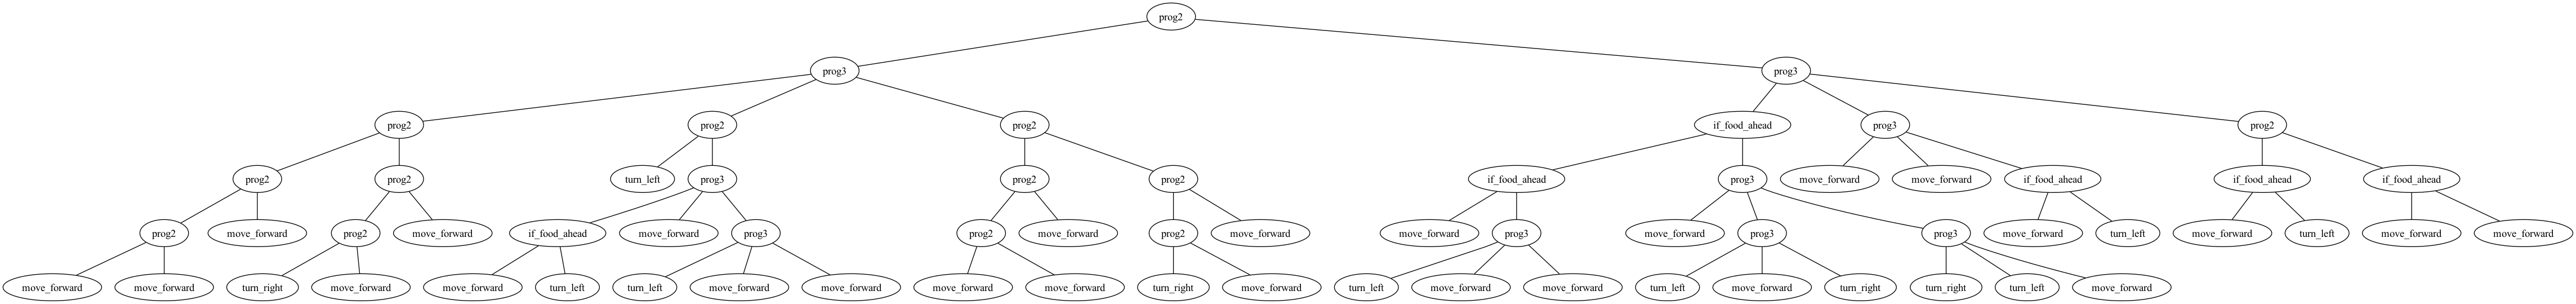

In [90]:
stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
stats_size = tools.Statistics(len)
mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
mstats.register("avg", numpy.mean)
mstats.register("std", numpy.std)
mstats.register("min", numpy.min)
mstats.register("max", numpy.max)
pop = toolbox.population(n=500)
hof = tools.HallOfFame(1)

pop, log = algorithms.eaSimple(
    pop,
    toolbox,
    cxpb=0.5,
    mutpb=0.1,
    ngen=150,
    stats=mstats,
    halloffame=hof,
    verbose=True,
)
best_ind = tools.selBest(pop, 1)[0]

ind = toolbox.individual()

nodes, edges, labels = gp.graph(best_ind)
tree = pgv.AGraph()
tree.add_nodes_from(nodes)
tree.add_edges_from(edges)
tree.layout(prog="dot")

for i in nodes:
    n = tree.get_node(i)
    n.attr["label"] = labels[i]

treePlot = tree.draw(format="png", prog="dot")
print(best_ind.fitness)
Image(treePlot)

   	      	                    fitness                    	                      size                     
   	      	-----------------------------------------------	-----------------------------------------------
gen	nevals	avg  	gen	max	min	nevals	std    	avg   	gen	max 	min	nevals	std    
0  	500   	4.812	0  	27 	0  	500   	5.43182	248.19	0  	2597	15 	500   	455.471
1  	282   	17.656	1  	27 	0  	282   	9.97906	68.754	1  	157 	25 	282   	29.8503
2  	235   	22.972	2  	30 	0  	235   	8.35196	97.54 	2  	126 	51 	235   	5.72017
3  	275   	23.52 	3  	34 	0  	275   	10.7546	94.524	3  	142 	1  	275   	9.14185
4  	306   	25.98 	4  	40 	0  	306   	11.2949	101.426	4  	168 	1  	306   	12.7047
5  	288   	29.24 	5  	40 	0  	288   	13.0144	113.166	5  	151 	3  	288   	11.7634
6  	266   	32.972	6  	42 	0  	266   	13.4552	121.56 	6  	191 	53 	266   	11.4441
7  	253   	33.712	7  	42 	0  	253   	13.7884	124.662	7  	199 	49 	253   	11.6915
8  	268   	32.87 	8  	42 	0  	268   	15.3652	128.424	8  	176 	1 

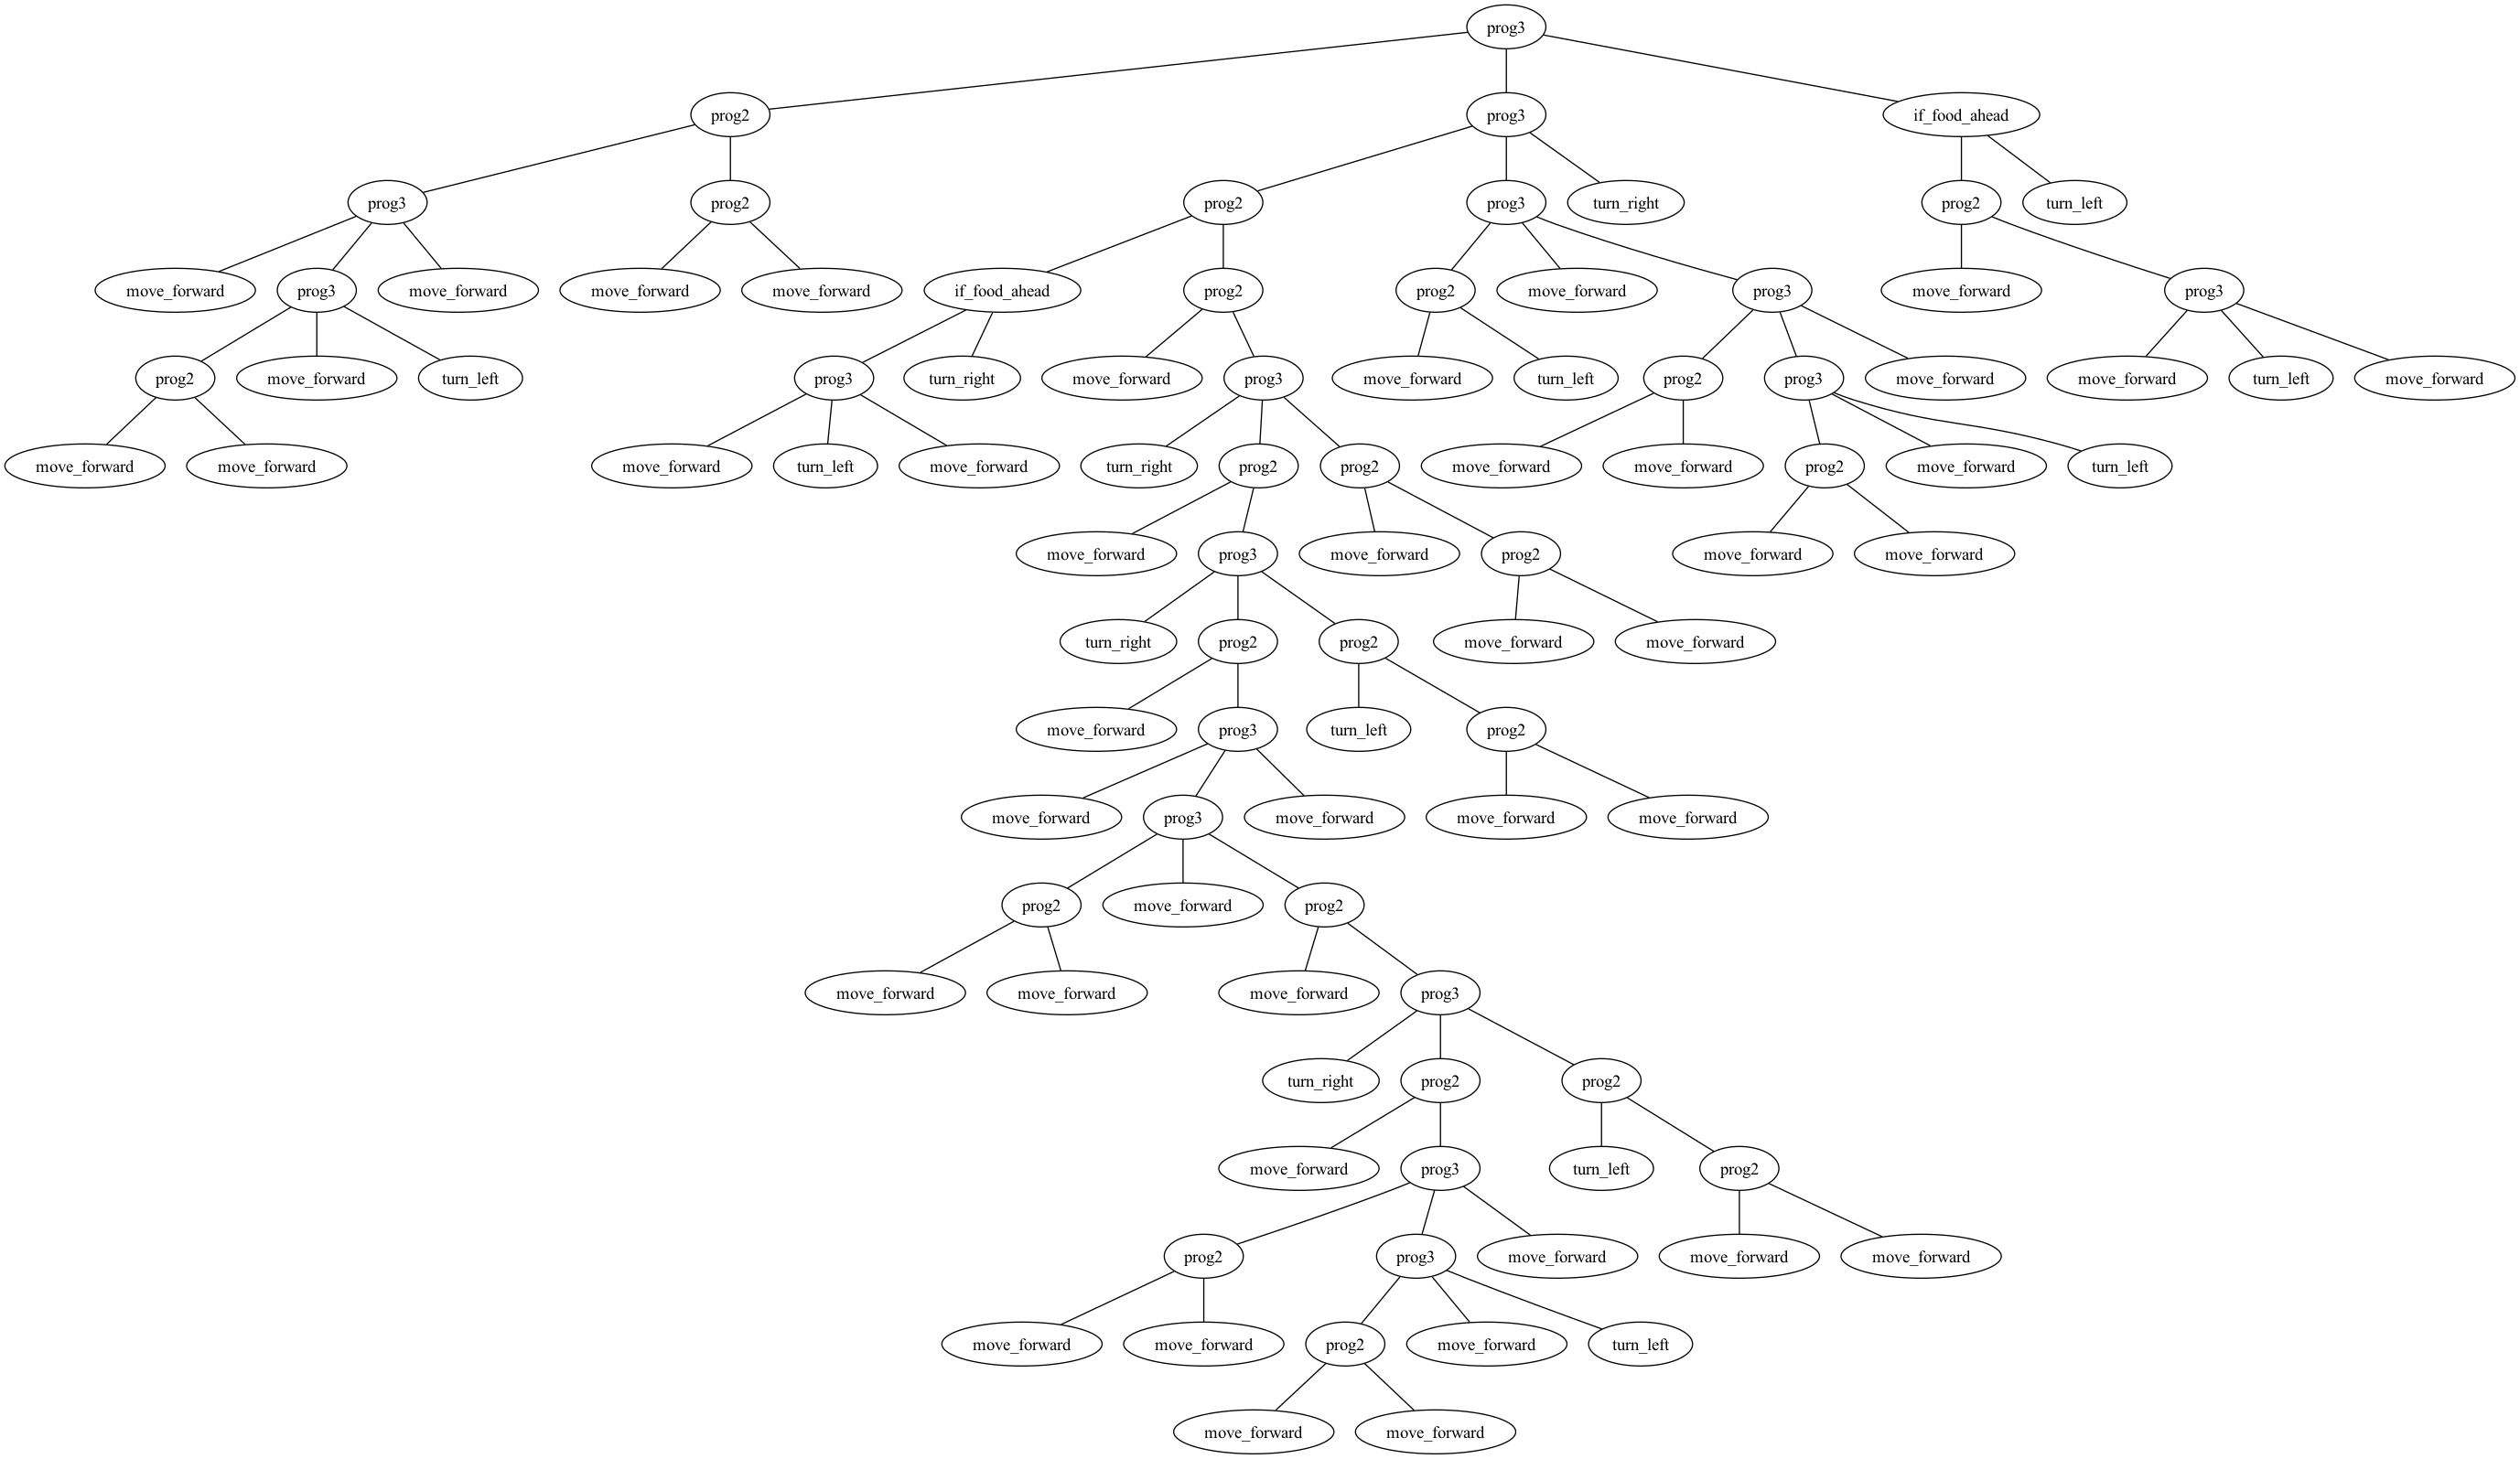

In [91]:
import operator

toolbox.register("evaluate", evalAnt)
toolbox.register(
    "select",
    tools.selDoubleTournament,
    fitness_size=len(pop),
    parsimony_size=2,
    fitness_first=True,
)
toolbox.decorate(
    "mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=20)
)
stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
stats_size = tools.Statistics(len)
mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
mstats.register("avg", numpy.mean)
mstats.register("std", numpy.std)
mstats.register("min", numpy.min)
mstats.register("max", numpy.max)
pop = toolbox.population(n=500)
hof = tools.HallOfFame(1)

pop, log = algorithms.eaSimple(
    pop,
    toolbox,
    cxpb=0.5,
    mutpb=0.1,
    ngen=150,
    stats=mstats,
    halloffame=hof,
    verbose=True,
)
best_ind = tools.selBest(pop, 1)[0]

ind = toolbox.individual()

nodes, edges, labels = gp.graph(best_ind)
tree = pgv.AGraph()
tree.add_nodes_from(nodes)
tree.add_edges_from(edges)
tree.layout(prog="dot")

for i in nodes:
    n = tree.get_node(i)
    n.attr["label"] = labels[i]

treePlot = tree.draw(format="png", prog="dot")
print(best_ind.fitness)
Image(treePlot)

## <span style="color:#0073e6">A note on the maximum tree depth in DEAP</span>

Since DEAP uses the Python parser to compile the code represented by the trees, it inherits from its limitations. The most commonly encountered restriction is the parsing stack limit. The Python interpreter parser stack limit is usually fixed between 92 and 99. This means that an expression can at most be composed of 91 succeeding primitives. In other words, a tree can have a maximum depth of 91 in DEAP.